# Sentiment Analysis, Part 2: Machine Learning With Spark On Google Cloud
---------------

## Contents
------------

__[1. Introduction](#bullet1)__

__[2. Creating A GCP Hadoop Cluster ](#bullet2)__

__[3. Getting Data From An Atlas Cluter](#bullet3)__

__[4. Basic Models With Spark ML Pipelines](#bullet4)__

__[5. Stemming With Custom Transformers](#bullet5)__

__[6. N-Grams & Parameter Tunning Using A Grid Search](#bullet6)__

__[7. Conclusions](#bullet7)__


## Introduction  <a class="anchor" id="bullet1"></a>
--------------

In the <a href="http://michael-harmon.com/posts/sentimentanalysis1">first part</a> of this two part blog post I went over the basics of ETL with PySpark and MongoDB.  In this second part I will go over the actual machine learning aspects of sentiment analysis using <a href="https://spark.apache.org/docs/latest/ml-guide.html">SparkML</a> (aka MLlib, it seems the name is changing).  Specifically, we'll be using <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">ML Pipelines</a> and <a href="https://en.wikipedia.org/wiki/Logistic_regression">Logistic Regression</a> to build a basic linear classifier for sentiment analysis. Many people use Support Vector Machines (SVM) because they handle high dimensional data well (which NLP problems definitely are) and allow for the use of non-linear kernels.  However, given the number of samples in our dataset and the fact Spark's <a href="https://spark.apache.org/docs/2.3.2/ml-classification-regression.html#linear-support-vector-machine">SVM</a> only supports linear Kernels (which have comparable performance to logistic regression) I decided to just stick with the simpler model, aka logistic regression.

After we build a baseline model for sentiment analysis, I'll introduce techniques to improve performance like removing stop words and using N-grams. I also introduce a custom Spark <a href="https://spark.apache.org/docs/1.6.2/ml-guide.html#transformers">Transformer</a> class that uses the <a href="https://www.nltk.org/">NLTK</a> to perform stemming.  Lastly, we'll review <a href="https://spark.apache.org/docs/latest/ml-tuning.html">hyper-parameter tunning</a> with cross-validation to optimize our model. The point of this post *is not too build the best classifier on a huge dataset, but rather to show how to piece together advanced concepts using PySpark... and at the same time get reasonable results.*

That said we will continue to use the 1.6 million <a href="https://www.kaggle.com/kazanova/sentiment140">tweets</a> from Kaggle which I loaded into my <a href="https://www.mongodb.com/cloud/atlas">Atlas MongoDB</a> cluster with the Spark ETL job that was discussed in the previous <a href="http://michael-harmon.com/blog/SentimentAnalysisP1.html">post</a>.  While 1.6 million tweets doesn't necessitate a distributed environment, using PySpark on this datset was a little too much for my whimpy 2013 Macbook Air and I needed to use a more powerful machine.  Luckily <a href="https://cloud.google.com/">Google Cloud Platform</a> (GCP) gives everyone free credits to start using their platform and I was able to use Spark on a <a href="https://hadoop.apache.org/">Hadoop</a> cluster using <a href="https://cloud.google.com/dataproc/">dataproc</a> and <a href="https://cloud.google.com/datalab/">datalab</a>. 


Let's get started!


## Creating A GCP Hadoop Cluster  <a class="anchor" id="bullet2"></a>
---------
I have been using Hadoop and Spark for quite some time now, but have never spun up my own cluster and gained a new found respect for Hadoop admins.  While Google does make the process easier, I still had to ask a friend for help to get things to work the way I wanted them to.  Between getting the correct version of Python as well as the correct version of NLTK on both the driver and worker nodes, the correct MongoDB connection for PySpark 2.3.2 and the time it takes to spin up and spin down a cluster I was very much done configuting Hadoop clusters on my own.  I want to say that made me a better person or at least a better data scientist, but I'm not so sure. :)

To start up the Hadoop cluster with two worker nodes (with the GCP free trial I could only use two worker nodes) I used the command below:

<img src="https://github.com/mdh266/TwitterSentimentAnalysis/blob/master/images/CreateCluster.png?raw=1">

You can see dataproc image version, the string for the MongoDB connection, as well as the version of Python in the above commands.  The bash scripts that I reference in my Google storage bucket for this project can be obtain from my repo <a href="https://github.com/mdh266/SentimentAnalysis/tree/master/GCP">here</a>.  After the cluster is created we can ssh onto the master node by going to the console and clicking on "*Compute Engine*" tab.  You will see a page like the one below:

<img src="https://github.com/mdh266/TwitterSentimentAnalysis/blob/master/images/MasterNode.png?raw=1">

We can ssh on the master node using the ssh tab to the right of the instance named **mikescluster-m**.  The "-m" signifies it is the master node while the other instances have "-w" signifiying they are worker nodes. After connecting to the mater node you can see all the <a href="https://data-flair.training/blogs/top-hadoop-hdfs-commands-tutorial/">Hadoop commands</a> available:

<img src="https://github.com/mdh266/TwitterSentimentAnalysis/blob/master/images/HDFS.png?raw=1">

We won't work on our Hadoop cluster through command line, but rather connect to the cluster through Jupyter notebooks using Google <a href="https://cloud.google.com/datalab/">datalab</a>. To do this involves creating an ssh-tunnel and proxy for Chrome, both of which I had no idea how to do, but luckily the same friend from before walked me through it.  The bash scripts I used to do these last two procedures are located in my repo <a href="https://github.com/mdh266/SentimentAnalysis/tree/master/GCP">here</a>. After those steps were completed we can enter the address into our web browser to see the Jupyter notebooks,

    http://mikescluster-m:8080
 
Note that the notebooks are running on the master node using port 8080 and that <a href="https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/YARN.html">YARN</a> can be seen from the same web address, but using port 8088.  I'll come back to YARN a little later.  Now that we have our Hadoop cluster up and running on Google Cloud we can talk about how to access our data.

## Getting The Dataset From An Atlas Cluster <a class="anchor" id="bullet3"></a>
---------

As I mentioned in the introduction I loaded the cleaned Twitter dataset into my Atlas MongoDB cluster as I discussed in the previous <a href="http://michael-harmon.com/blog/SentimentAnalysisP1.html">post</a>.  In this post I won't go over the ETL process again, but will show how to connect PySpark to the Atlas cluster.  One thing to highlight here is that in order to keep my collection within the memory limits of the free tier I had to store the data as strings instead of tokens as I showed in the previous post. (See the ETL job here <a href="https://github.com/mdh266/SentimentAnalysis/blob/master/ETL/BasicETL.py">here</a> for details)  Therefore we'll do have to tokenize our strings again here.

The first step to connecting to the database is to create a connection url string that contains the cluster address, user info, password as well as database and collection name in the dictionary below:

In [1]:
mongo_conn = {"address"    : "harmoncluster-xsarp.mongodb.net/", 
              "db_name"    : "db_twitter",
              "collection" : "tweets",
              "user"       : "",
              "password"   : ""}

url   = "mongodb+srv://{user}:{password}@{address}{db_name}.{collection}".format(**mongo_conn)

Then we create a dataframe from the documents in the collection using the <code>spark.read</code> command, passing in the connection url as our option and specifying that we are using MongoDB as the format:

In [2]:
df = spark.read\
          .format("com.mongodb.spark.sql.DefaultSource")\
          .option("uri",url)\
          .load()

At this point while the collection on the Atlas cluster has not been pulled to our Hadoop cluster yet, we would see an error if there was a mistake in our connection string.  Additionally, at this point the dataframe allows us to see some metadata on the collection, i.e. the "schema",

In [3]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- sentiment: integer (nullable = true)
 |-- tweet_clean: string (nullable = true)



You can see that each document has an <code>id</code>, <code>sentiment</code> and cleaneed tweet.  Let's just pull the <code>tweet_clean</code> as well as `sentiment` fields and rename `sentiment` to `label`:

In [5]:
df2 = df.select("tweet_clean","sentiment")\
        .withColumnRenamed("sentiment", "label")

Then let's split the dataframe into training and testing sets (using 80% of the data for training and 20% for testing) with a seed (1234),

In [6]:
train, test = df2.randomSplit([0.80, 0.20], 1234)

Now we can look at the number of tweets in the training set that have positive and negative sentiment. Note, since we will be using this dataframe many times below we will cache it to achieve better runtime performance.

In [7]:
train.cache()

DataFrame[tweet_clean: string, label: int]

In [8]:
train.groupby("label")\
     .count()\
     .show()

+-----+------+
|label| count|
+-----+------+
|    1|637317|
|    0|639237|
+-----+------+



We can see that the two classes are well balanced, with over half a million positive and negative teets.  We do the same for the testing set:

In [9]:
test.cache()

DataFrame[tweet_clean: string, label: int]

In [10]:
test.groupby("label")\
    .count()\
    .show()

+-----+------+
|label| count|
+-----+------+
|    1|159635|
|    0|159840|
+-----+------+



Again, the classes are well balanced.  This is great because we don't have to worry about dealing with imbalanced classes and *accuracy and ROC's area under the curve (AUC) are good metrics to see how well our models are performing.*

Now let's build our baseline model.

## Basic Models With Spark ML Pipelines <a class="anchor" id="bullet4"></a>
------------
In this section I'll go over how to build a basic logistic regression model using Spark <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">ML Pipelines</a>.  ML Pipelines are similar to <a href="https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html">Scikit-learn Pipelines</a>. We import the basic modules:

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

Next we instantiate our classification evalutor class and pass the label of the output column (the prediction column) from the model:

In [201]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

# get the name of the metric used
evaluator.getMetricName()

'areaUnderROC'

We'll be using the <a href="https://en.wikipedia.org/wiki/Bag-of-words_model">bag of words (BOW) model</a> to build features from tweets for our model.  *In the bag-of-words model, a document (in this case tweet) is represented as "bag" or list of its words, disregarding grammar and ordering, but keeping the multiplicity of the words.*  A two document example is:

- **D1:**  Hi, I am Mike and I like Boston.

- **D2:**  Boston is a city and people in Boston like the Red Sox.

From these two documents, a list, or 'bag-of-words' is constructed

    bag = ['Hi', 'I', 'am', 'Mike', 'and', 'like', 'Boston', 'is', 
           'a', 'city, 'and', 'people', 'in', 'the', 'red', 'sox]


Notice how in our bag-of-words we have dropped repetitions of the words 'I', 'is' and 'Mike'. I will show how multiplicity of words enters into our model next. 

After transforming the text (all documents) into a "bag of words" we generate a vector for each document that represents the number of times each word (or more generally token) in the BOW appears in the text. The order of entries in the BOW vector corresponds to the order of the entries in the bag-of-words list.  For example, document D1 would have a vector,

    [1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 0 ,0, 0, 0, 0, 0]
    
while the second document, D2, would have the vector,

    [0, 0, 0, 0, 0, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]

Each entry of the lists refers to frequency or count of the corresponding entry in the bag-of-words list.  When we have a stacked collection of (row) vectors, or matrix, where each row corresponds to a document (vector), and each column corresponds to a word in the bag-of-words list, then this will be known as our **term-frequency ($\text{tf}$) [document matrix](https://en.wikipedia.org/wiki/Document-term_matrix)**. The general formula for an entry in the $\text{tf}$ matrix is,

$$\text{tf}(d,t) \,  = \, f_{t,d}$$
    
where $f_{t,d}$ is the number of times the term $t$ occurs in document $d \in \mathcal{D}$, where $\mathcal{D}$ is our text corpus.  We can create a term-frequency matrix using Spark's <a href="https://spark.apache.org/docs/latest/ml-features.html#tf-idf">HashingTF</a> class. To see the difference between HashingTF and <a href="https://spark.apache.org/docs/latest/ml-features.html#countvectorizer">CounterVectorizer</a> see this <a href="https://stackoverflow.com/questions/35205865/what-is-the-difference-between-hashingtf-and-countvectorizer-in-spark">stackoverflow post</a>.

Most often term-frequency alone is not a good measure of the importance of a word/term to a document's sentiment.  Very common words like "the", "a", "to" are almost always the terms with the highest frequency in the text. Thus, having a high raw count of the number of times a term appears in a document does not necessarily mean that the corresponding word is more important to the sentiment of the document.

To circumvent the limination of term-frequency, we often normalize it by the **inverse document frequency (idf)**.  This results in the **term frequency-inverse document frequency (tf-idf)** matrix.  The *inverse document frequency is a measure of how much information the word provides, that is, whether the term is common or rare across all documents in the corpus*.  We can give a formal defintion of the inverse-document-frequency by letting $\mathcal{D}$ be the corpus or the set of all documents and $N_{\mathcal{D}}$ is the number of documents in the corpus and $N_{t,D}$ be the number of documents that contain the term $t$ then, 

$$idf(t,\mathcal{D}) \, = \,  \log\left(\frac{N_{\mathcal{D}}}{1 + N_{t,\mathcal{D}}}\right) \, = \, -  \log\left(\frac{1 + N_{t,\mathcal{D}}}{N_{\mathcal{D}}}\right) $$

The reason for the presence of the $1$ is for smoothing.  Without it, if the term/word did not appear in any training documents, then its inverse-document-frequency would be $idf(t,\mathcal{D}) = \infty$.  However, with the presense of the $1$ it will now have $idf(t,\mathcal{D}) = 0$.


Now we can formally define the term frequnecy-inverse document frequency as a normalized version of term-frequency,


$$\text{tf-idf}(t,d) \, = \, tf(t,d) \cdot idf(t,\mathcal{D}) $$

Like the term-frequency, the term frequency-inverse document frequency is a sparse matrix, where again, each row is a document in our training corpus ($\mathcal{D}$) and each column corresponds to a term/word in the bag-of-words list.  The $\text{tf-idf}$ matrix can be constructed using the <a href="https://spark.apache.org/docs/latest/ml-features.html#tf-idf">SparkML IDF</a> class.


Now that we have gotten the definition of TF-IDF out of the way we can discuss the steps in building a basic pipeline.   These include,

    - tokenization
    - creating term frequency
    - creating term frequency inverse document frequency 
    - fitting a logistic regression model to the BOW created from the previous steps
    
This is all done (amazingly!) in the short few lines below:

In [67]:
# create tokens from tweets
tk = Tokenizer(inputCol= "tweet_clean", outputCol = "tokens")

# create term frequencies for each of the tokens
tf1 = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=1e5)

# create tf-idf for each of the tokens
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)

# create basic logistic regression model
lr = LogisticRegression(maxIter=20)

# create entire pipeline
basic_pipeline = Pipeline(stages=[tk, tf1, idf, lr])

The setting `numFeatures=1e5` means that our bag-of-words "vocabulary" contains 100,000 words (see above listed stackeroverflow comment for explanation of what this means). The filter `minDocFreq=2.0` requires that a word or token must appear a minimum of 2 documents to be counted as a feature (column).  **This parameter can act as form a of regularization.  Setting this value to larger integers increases the regularization by reducing the number of words we consider.** This helps to combat overfitting by eliminating words which occur very rarely so that they do not influence our model.

Now we can execute the entire pipleine of tokenization, feature extraction (tf-idf) and train the model all with the following command:

In [68]:
model1         = basic_pipeline.fit(train)

Once we have trained the pipeline model we can predict it's perfromance on the testing set using the <code>transform</code> method and the <code>evaluate</code> method of the evaluator object.

In [69]:
# predict on test set
predictions1   = model1.transform(test)

# get the performance on the test set
score1         = evaluator.evaluate(predictions1)

print("AUC SCORE: {}".format(score1))

AUC SCORE: 0.8851466578396061


We can also get the accuracy on the testing set. I couldn't really find any good documentation about how to do this without using the old MLlib (RDD based) library.  What made this process even more confusing is that I had to use <a href="https://spark.apache.org/docs/2.3.2/mllib-evaluation-metrics.html">MulticlassMetrics</a> class to evualate the binary outcome ( the `BinaryClassificationMetrics` class only had area under the curve (AUC) and for ROC curve and AUC for Precision-Recall curve).  The code snippet to get the accuracy on the testing set is:

In [216]:
predictedAndLabels = predictions1.select(["prediction","label"])\
                                 .rdd.map(lambda r : (float(r[0]), float(r[1])))

from pyspark.mllib.evaluation import MulticlassMetrics

metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

Test Set Accuracy: 0.8138070271539244


A score of 0.885 for the AUC of the ROC curve and 81% accuracy is pretty good for Twitter sentiment analyis, but let's see if we can make any improvements using more techniques from natural language processing.

### Removing Stop Words

One trick people use as a prepocessing step in NLP is to remove stop words, i.e. common words that do not add any additional information into the model.  Examples of stop words are: 'a', 'the', 'and', etc.  We will remove stops from our tokens by using the <a href="https://spark.apache.org/docs/2.3.2/ml-features.html#stopwordsremover">StopWordsRemover</a> class.  We import it below,

In [70]:
from pyspark.ml.feature import StopWordsRemover

Then instantiate a new StopWordsRemover object setting input column to be result of the tokenization procedure.  Notice that the input column name for the HashingTF object is the same as the output column name for the StopWordRemover:

In [71]:
sw  = StopWordsRemover(inputCol="tokens", outputCol="filtered")
tf2 = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=1e5)

We can define our pipeline, train the new model and evaluate its performance on the testing set:

In [72]:
sw_pipleline  = Pipeline(stages=[tk, sw, tf2, idf, lr])

model2        = stopwords_pipleline.fit(train)
predictions2  = model2.transform(test)
score2        = evaluator.evaluate(predictions2)

print("AUC SCORE: {}".format(score2))

AUC SCORE: 0.8725249381777652


Notice how easy it was to add a new stage to our ML Pipeline model!

We can see that the AUC for our ROC went down by a little over 1.5%.  At first I was pretty puzzled by this and spent a lot of time trying to fix it only to learn that blindly removing stop words isn't always the best practice for sentiment analysis, especially when it comes to <a href="http://www.lrec-conf.org/proceedings/lrec2014/pdf/292_Paper.pdf">tweets</a>.  Since removing stopped words gave our model worse performanace, we won't use it going forward.  However, it's worthwhile to see examples of the words that were removed:

In [162]:
predictions2.select(["tweet_clean","tokens","filtered"]).show(5)

+--------------------+--------------------+--------------------+
|         tweet_clean|              tokens|            filtered|
+--------------------+--------------------+--------------------+
|a and yr old both...|[a, and, yr, old,...|[yr, old, girls, ...|
|a baby bird fell ...|[a, baby, bird, f...|[baby, bird, fell...|
|a baby llama was ...|[a, baby, llama, ...|[baby, llama, bor...|
|a beautiful day t...|[a, beautiful, da...|[beautiful, day, ...|
|a bicyclist was j...|[a, bicyclist, wa...|[bicyclist, hit, ...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



We can see that words like, 'a', 'and', 'was', and 'both' were removed.  Removing stop words is more helpful for the case of <a href="http://michael-harmon.com/blog/NLP.html">document classification</a>, where often the class a document belongs to is determined by a few key words and removing stop words can help to understand what those key words are. 


## Stemming With Customer Tranformers <a class="anchor" id="bullet5"></a>
------------

Another technique for preprocessing in NLP is stemming.  We will use the Natural Language Tool Kit (<a href="https://www.nltk.org/">NLTK</a> ) with the Porter Stemmer for stemming.  Stemming is the process of reducing words down to their root; for example from Wikipedia:

...the Porter algorithm reduces, argue, argued, argues, arguing, and argus all get reduced to the stem argu 

Stemming is used as an approximate method for grouping words with a similar basic meaning together.  For NLP and the bag-of-words model this reduces the dimension of our feature space since variations in words that would normally be counted seperately are reduced to one word that is counted collectively. 


For some reason gcloud kept installing the wrong version of NLTK and inorder to get the correct version on both the driver and the workers I had to install within the notebook.

In [30]:
%sh
pip install -U nltk==3.4

  Running setup.py bdist_wheel for nltk: started
  Running setup.py bdist_wheel for nltk: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/4b/c8/24/b2343664bcceb7147efeb21c0b23703a05b23fcfeaceaa2a1e
Successfully built nltk
  Found existing installation: nltk 3.2.1
    Uninstalling nltk-3.2.1:
      Successfully uninstalled nltk-3.2.1


Now we can import the NLTK to and check its version is correct.

In [1]:
import nltk
print(nltk.__version__)
from nltk.stem.porter import PorterStemmer

3.4


Before we dive into using NLTK with PySpark let's go over an example how stemming with the NLTK works on a simple sentence.  First we instantiate the PorterStemmer object and tokenize a sentence:

In [3]:
stemmer = PorterStemmer()

tokens  = "my feelings having studied all day".split(" ")
print("raw tokens: {}".format(tokens))

raw tokens: ['my', 'feelings', 'having', 'studied', 'all', 'day']


Then we can apply the stemmer's stem function to each token in the array:

In [4]:
tokens_stemmed = [stemmer.stem(token) for token in tokens]
print("clean tokens: {}".format(tokens_stemmed))

clean tokens: ['my', 'feel', 'have', 'studi', 'all', 'day']


We can see that the word 'feelings' has been reduced to 'feel', 'having' to 'has' and 'studied' to 'studi'.  I should note that stemming, like stop word removal, might not always be helpful in deciding the sentiment since the way a word is used might effect the sentiment.  

Inorder to use the Porter stemmer within a ML Pipeline we must create a custom <a href="https://spark.apache.org/docs/latest/ml-pipeline.html#transformers">Transformer</a>.  The Transformer class will allow us to apply non-Spark functions and transformations as stages within our ML Pipeline.  We create a customer `PortersStemming` class which extends the PySpark's Transformer class, HasInputCol class and HasOutputCol class; see <a href="https://github.com/apache/spark/blob/master/python/pyspark/ml/param/shared.py">here</a> for these class definitions.  This was also the first time I have used <a href="https://www.programiz.com/python-programming/multiple-inheritance">multiple inheritence</a> in Python which is pretty cool!

In [35]:
from pyspark import keyword_only
import pyspark.sql.functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import ArrayType, StringType
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param


class PorterStemming(Transformer, HasInputCol, HasOutputCol):
    """
    PosterStemming class using the NLTK Porter Stemmer
    
    This comes from https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    Adapted to work with the Porter Stemmer from NLTK.
    """
    
    @keyword_only
    def __init__(self, 
                 inputCol  : str = None, 
                 outputCol : str = None, 
                 min_size  : int = None):
        """
        Constructor takes in the input column name, output column name,
        plus the minimum legnth of a token (min_size)
        """
        # call Transformer classes constructor since were extending it.
        super(Transformer, self).__init__()

        # set Parameter objects minimum token size
        self.min_size = Param(self, "min_size", "")
        self._setDefault(min_size=0)

        # set the input keywork arguments
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

        # initialize Stemmer object
        self.stemmer  = PorterStemmer()

        
    @keyword_only
    def setParams(self, 
                  inputCol  : str = None, 
                  outputCol : str = None, 
                  min_size  : int = None
      ) -> None:
        """
        Function to set the keyword arguemnts
        """
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    

    def _stem_func(self, words  : list) -> list:
        """
        Stemmer function call that performs stemming on a
        list of tokens in words and returns a list of tokens
        that have meet the minimum length requiremnt.
        """
        # We need a way to get min_size and cannot access it 
        # with self.min_size
        min_size       = self.getMinSize()

        # stem that actual tokens by applying 
        # self.stemmer.stem function to each token in 
        # the words list
        stemmed_words  = map(self.stemmer.stem, words)

        # now create the new list of tokens from
        # stemmed_words by filtering out those
        # that are not of legnth > min_size
        filtered_words = filter(lambda x: len(x) > min_size, stemmed_words)

        return list(filtered_words)
    
    def _transform(self, df: DataFrame) -> DataFrame:
        """
        Transform function is the method that is called in the 
        MLPipleline.  We have to override this function for our own use
        and have it call the _stem_func.

        Notice how it takes in a type DataFrame and returns type Dataframe
        """
        # Get the names of the input and output columns to use
        out_col       = self.getOutputCol()
        in_col        = self.getInputCol()

        # create the stemming function UDF by wrapping the stemmer 
        # method function
        stem_func_udf = F.udf(self._stem_func, ArrayType(StringType()))
        
        # now apply that UDF to the column in the dataframe to return
        # a new column that has the same list of words after being stemmed
        df2           = df.withColumn(out_col, stem_func_udf(df[in_col]))

        return df2
  
  
    def setMinSize(self,value):
        """
        This method sets the minimum size value
        for the _paramMap dictionary.
        """
        self._paramMap[self.min_size] = value
        return self

    def getMinSize(self) -> int:
        """
        This method uses the parent classes (Transformer)
        .getOrDefault method to get the minimum
        size of a token.
        """
        return self.getOrDefault(self.min_size)

        

After looking at the PySpark <a href="https://github.com/apache/spark/blob/master/python/pyspark/ml/base.py">source code</a> I learned that the Tranformer class is an <a href="https://docs.python.org/3/glossary.html#term-abstract-base-class">abstract base class</a> that specifically requires users to override the <code>_transform</code> method. After a lot of trial and error I found that the key steps to creating a custom transformer are:

- Creating a <code>Param</code> object (see <a href="https://github.com/apache/spark/blob/master/python/pyspark/ml/param/__init__.py">here</a> for class definition) for each paramster in the constructor that will hold the user defined parameter names, values and default values.


- Create the `_input_kwargs` member variable and set it. 


- Write a new defintion for the <code>_transform</code> method that applies a customer transformation to the <code>inputCol</code> of the dataframe and returns the same dataframe with a new column named <code>outputCol</code> that is the result of the transformation defined in this code block.


I was also was curious about the <code>keyword_only</code> decorator and after <a href="http://spark.apache.org/docs/2.2.0/api/python/_modules/pyspark.html">digging deeper</a> found it is "a decorator that forces keyword arguments in the wrapped method and saves actual input keyword arguments in `_input_kwargs`."




### Stemming with the NLTK's PorterStemmer

Let's apply stemming to our problem without removing stop words to see if it improves the performance of our model.

In [137]:
stem2 = PorterStemming(inputCol="tokens", outputCol="stemmed")

We'll do things a little differently this time for the sake of runtime performance.  Stemming is an expensive operation because it requires the use of a custom transformer.  Anytime we introduce custom functions like UDFs or special Python functions outside of the SparkSQL functions we pay a runtime <a href="https://medium.com/teads-engineering/spark-performance-tuning-from-the-trenches-7cbde521cf60">penalty</a>.  Therefore we want to be performing operations with custom functions as little as possible. 

Since we will use stemming on multiple different models we will create new training and testing datasets that are already pre-stemmed.  This avoids repeatedly having to tokenize and stem our datasets each time we train and test one of our models.  We define a pipeline for creating the new datatset below,

In [ ]:
stem_pipeline = Pipeline(stages= [tk, stem2]).fit(train)

Then we transform the training and testing set and cache them so they are in memory and can be used without having to recreate them,

In [138]:
train_stem = stem_pipeline.transform(train)\
                          .where(F.size(F.col("stemmed")) >= 1)

test_stem  = stem_pipeline.transform(test)\
                          .where(F.size(F.col("stemmed")) >= 1)

# cache them to avoid running stemming 
# each iteration in the grid search
train_stem.cache()
test_stem.cache()

DataFrame[tweet_clean: string, label: int, tokens: array<string>, stemmed: array<string>]

Let's see some of the results of stemming the tweets:

In [160]:
test_stem.show(5)

+--------------------+-----+--------------------+--------------------+
|         tweet_clean|label|              tokens|             stemmed|
+--------------------+-----+--------------------+--------------------+
|a and yr old both...|    1|[a, and, yr, old,...|[a, and, yr, old,...|
|a baby bird fell ...|    0|[a, baby, bird, f...|[a, babi, bird, f...|
|a baby llama was ...|    0|[a, baby, llama, ...|[a, babi, llama, ...|
|a beautiful day t...|    1|[a, beautiful, da...|[a, beauti, day, ...|
|a bicyclist was j...|    0|[a, bicyclist, wa...|[a, bicyclist, wa...|
+--------------------+-----+--------------------+--------------------+
only showing top 5 rows



We can see that the words 'baby' and 'beautiful' are reduced to 'babi' and 'beauti' respectively.  


Let's now build our second pipeline (using TF-IDF and logistic regression) based off the pre-stemmed training dataset and test it on the pre-stemmed testing set.

In [139]:
# create the new pipline
idf                 = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)
lr                  = LogisticRegression(maxIter=20)

stemming_pipeline2  = Pipeline(stages= [tf3, idf, lr])

# fit and get predictions
model4         = stemming_pipeline2.fit(train_stem)
predictions4   = model4.transform(test_stem)
score4         = evaluator.evaluate(predictions4)

The AUC of the new model on the test set is,

In [140]:
print("AUC SCORE: {}".format(score4))

AUC SCORE: 0.88040135203641


We can see that adding stemming degrades the AUC slightly compared to the baseline model, but *we'll keep using stemming in our future models since the jury's not out on whether it will improve future models*.  One thing I will mention here is that I did try using stop word removal and stemming together, but this resulted in worse performance than just stop word removal alone.

As I mentioned previously, stemming using a customer Transformer is expensive.  One way I could see that it is an expensive operation is by going to <a href="https://hadoop.apache.org/docs/current/hadoop-yarn/hadoop-yarn-site/YARN.html">YARN</a> (on our cluster this is the address: http://mikescluster-m:8088) shown below:

<img src="https://github.com/mdh266/TwitterSentimentAnalysis/blob/master/images/YARN.png?raw=1">


Then clicking on ApplicationMaster in the bottom right hand corner.  This leads you to the <a href="https://jaceklaskowski.gitbooks.io/mastering-apache-spark/spark-webui.html">Spark Web UI </a>page:


<img src="https://github.com/mdh266/TwitterSentimentAnalysis/blob/master/images/SparkUI.png?raw=1">

Clicking on stages we can see the time and memory it takes for each stage in our pipelines (or more generally jobs). I used the Spark Web UI constantly to track the progress of my jobs and noticed that stemming caused the TF-IDF stages to take much longer than they did without it.




## N-Grams And Parameter Tunning With Cross Validation <a class="anchor" id="bullet6"></a>
--------------------

The last preprocessing technique we'll try to improve the predictive power of our model is to use N-grams.  This technique is used to capture combinations of words that effect the sentiment of the document.  For instance the sentence,

    the food is not bad
    
is naturally assumed to have a positive sentiment, or atleast non-negative sentiment. After tokenizing the sentence we would have the list,

    ["the", "food", "is", "not", "bad"]
    
    
Using the normal bag-of-words with TF-IDF, our model would see the word 'bad' and most likely assume the that the sentence has negative sentiment.  This is because the presence of the token 'bad' is usually associated with a negative sentiment.  What our model fails to ascertain is that the presence of the word 'not' before 'bad' leads to the combination 'not bad' which normally coincides with a positive sentiment. In order to pick up these types of combinations of words we introduce n-grams.  Bigrams combine consecutive pairs of words in our bag-of-words model.  Using bigrams the previous example sentence would be,

    [["the", "food"], ["food, "is"], ["is", "not"], ["not,"bad"]]
    

Using bigrams our model will see be the combination `["not", "bad"]` and be able to ascertain that sentiment of the sentence is postive. Bigrams use consecutive pairs of words to form tokens for our model, N-grams generalize this process to combine N consecutive words to form tokens for our bag-of-words model.

Another thing I should point out is that **while using bigrams introduces consecutive pairs of words in documents as tokens in the bag-of-words model the order of those bigrams in the document is not taken into consideration. Each tweet is reduced to a set of bigrams and the bag-of-words model treats those bigrams similar to categorial features/one-hot encoding.**  The difference with bag-of-words and one-hot encoding being that instead of the value in each column for a token being 0 or 1 based on its presence in the tweet, the value is 0-N with N being how many times the token appears in the tweet.

### Basic model with bigrams

We import the NGram class from the features module and use bigrams (`n=2`) for our model, 

In [ ]:
from pyspark.ml.feature import NGram

bigram = NGram(inputCol="tokens", outputCol="bigrams", n=2)

Then we form a pipeline by first tokenizing the words in the sentence, forming bigrams, performing TF-IDF and then fitting the logistic regressionm model.  One thing to note is that introducing bigrams means that our bag-of-words model has features that are based on pairs of word instead of individual words.  Since the number of combinations of pairs of words is "larger" than the number of individual words we increase the number of features in our model to `200,000` instead of `100,000`.

We define the new pipeline, train, test and evaluate the model:

In [130]:
tf5   = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

bigram_pipeline  = Pipeline(stages= [tk, bigram, tf5, idf, lr])

model5           = bigram_pipeline.fit(train)
predictions5     = model5.transform(test)

score5           = evaluator.evaluate(predictions5)

In [131]:
print("AUC SCORE: {}".format(score5))

AUC SCORE: 0.890927326083407


We can see that using bigrams provides an improvement to the basic model!

### Stemming with bigrams

While using stemming alone did not lead to an improvement over our baseline model, using stemming with bigrams might lead to an improvement.  My reason for believing this is that while bigrams improve the performance of our model, they also increases the dimension of our problem. By introducing stemming we would reduce the number of variations of the word pairs, (the variance in our data) and also the reduce the dimension of our feature space.  

We create our new pipeline on the pre-stemmed training and testing datasets as well as evaulate the model:

In [213]:
bigram2 = NGram(inputCol="stemmed", outputCol="bigrams", n=2)

tf6     = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

idf     = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=2.0)

lr      = LogisticRegression(maxIter=20)

stem_bigram_pipeline  = Pipeline(stages= [bigram2, tf6, idf, lr])

model6                = stem_bigram_pipeline.fit(train_stem)
predictions6          = model6.transform(test_stem)

score6                = evaluator.evaluate(predictions6)

In [1]:
print("AUC SCORE: {}".format(score)) 

AUC SCORE: 0.8929975456358279


We can see that using bigrams and stemming leads to not only an improvement over the baseline model, but also the bigram model! My intuition was right! :)

Let's take a look at examples of what each stage in the above pipeline did to the tweet:

In [165]:
predictions6.select(["tweet_clean","tokens","stemmed","bigrams"]).show(5)

+--------------------+--------------------+--------------------+--------------------+
|         tweet_clean|              tokens|             stemmed|             bigrams|
+--------------------+--------------------+--------------------+--------------------+
|a and yr old both...|[a, and, yr, old,...|[a, and, yr, old,...|[a and, and yr, y...|
|a baby bird fell ...|[a, baby, bird, f...|[a, babi, bird, f...|[a babi, babi bir...|
|a baby llama was ...|[a, baby, llama, ...|[a, babi, llama, ...|[a babi, babi lla...|
|a beautiful day t...|[a, beautiful, da...|[a, beauti, day, ...|[a beauti, beauti...|
|a bicyclist was j...|[a, bicyclist, wa...|[a, bicyclist, wa...|[a bicyclist, bic...|
+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



### Parameter Tunning Using A Grid Search

Now let's try to improve the performance of the stemming-bigram model by tunning the hyperparameters in some of the stages in the pipeline.  Tunning the hyperparameters in our model involves using a grid search which evaluates all hyperparameters we want to consider and returns the model with the best results.  In order to get the best results from our model for out-of-sample performance we perform <a href="https://en.wikipedia.org/wiki/Cross-validation_(statistics)">cross-validation</a> within each of the parameter values in the grid search.  Using cross validation within the grid search reduces the chances of overfitting our model and will hopefully give us the best performance on the test set. 


In order to perform a grid search with cross validation we import the classes,

In [ ]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

Then define the model pipeline,

In [ ]:
bigram2 = NGram(inputCol="stemmed", outputCol="bigrams", n=2)

tf6     = HashingTF(inputCol="bigrams", outputCol="rawFeatures", numFeatures=2e5)

idf     = IDF(inputCol="rawFeatures", outputCol="features")

lr      = LogisticRegression(maxIter=20)

stem_bigram_pipeline  = Pipeline(stages= [bigram2, tf6, idf, lr])

Next we declare the 'hyperparamter grid' we want to search over using the `ParamGridBuilder` class,

In [ ]:
paramGrid = ParamGridBuilder() \
                        .addGrid(idf.minDocFreq, [2, 5]) \
                        .addGrid(lr.regParam, [0.0, 0.1]) \
                        .build()

This is a small grid because the training time on tiny 2-node Hadoop cluster is somewhat long. Again, the point of this blogpost is not to get the best performance possibles, but rather to show how the pieces of the SparkML library fit together.  I will remark that these hyperparameter choices just seeing what level or regularization we want to apply in feature generation stage (`idf.minDocFreq`) and model fitting stage (`lr.regParam`) of our ML Pipeline.  

Now lets's define the grid search with cross validation using the `CrossValidator` class,

In [145]:
crossval = CrossValidator(estimator          = stem_bigram_pipeline,
                          estimatorParamMaps = paramGrid,
                          evaluator          = BinaryClassificationEvaluator(),
                          numFolds           = 3)

Notice for that we need

- the Spark ML Pipeline
- the parameter grid values
- the metric used to evulate the performance of the models
- the size of the fold's (k) in cross validation


While values of `k=5` or `k=10` are most often used in cross validation we have large sample size in our training set and the time it takes to train on the cluster is long so I chose a smaller value of 3.  We could also have used the <code>TrainValidationSplit</code> class which only evaluates each parameter choice once instead of multiple times over each of the $K$ folds in <code>CrossValidator</code>.  This estimator is not as expensive as cross validation,
but can produce less reliable results when dataset isn't large enough.  See the <a href="https://spark.apache.org/docs/latest/ml-tuning.html#train-validation-split">documenation</a> for more infromation.


Now we can perform the grid search!

In [199]:
model    = crossval.fit(train_stem)

Then make predictions on testing set to get the model performance, 

In [209]:
predictions   = model.transform(test_stem)
score         = evaluator.evaluate(predictions)

In [210]:
print("AUC SCORE: {}".format(score))

AUC SCORE: 0.8914174745931814


Notice that while this result is better than baseline model, it is not as good as the stemmed-bigram model we first came up with.  We could ostensibly try more parameter values and larger $k$ values to get a better score, but the performance of this model is good enough.  

Next let's get the accuracy of the model on the testing set.  We do this by first getting the best model from the grid search,

In [148]:
bestModel = model.bestModel

Then we can get the accuracy just as we did with the baseline model,

In [211]:
predictedAndLabels = predictions.select(["prediction","label"])\
                                .rdd.map(lambda r : (float(r[0]), float(r[1])))

In [215]:
metrics = MulticlassMetrics(predictedAndLabels)

print("Test Set Accuracy: {}".format(metrics.accuracy))

Test Set Accuracy: 0.8153407934893184


81.5% accuracy with a AUC of 0.891 is pretty good for Twitter sentiment analysis!  

Let's now find out what the parameters from the gridsearch are that resulted in the best model.  We can see the various stages in the model pipeline by using the `.stages` command:

In [149]:
bestModel.stages

[NGram_40759d058add92d09ae5,
 HashingTF_4a6e8ba9ed3f963b503d,
 IDF_46d39c742a5e256dfe52,
 LogisticRegression_452b8fd5858100e48a64]

Then within each stage we can get the hyperparameter value by passing the name to the `explainParam` method:

In [150]:
bestModel.stages[2].explainParam('minDocFreq')

'minDocFreq: minimum number of documents in which a term should appear for filtering (>= 0) (default: 0, current: 5)'

In [217]:
bestModel.stages[-1].explainParam('regParam')

'regParam: regularization parameter (>= 0) (default: 0.0, current: 0.1)'

We can see that the best model came from a result of having `minDocFreq=5` and `regParam=0.1` in the IDF and Logistic Regression stage of our pipeline respectively.

The last thing we'll do is get an idea of the ROC curve for our best model.  I could only do this for the training set by getting the logistic regression stages' summary:

In [143]:
summary = bestModel.stages[-1].summary

Then getting the True Postive Rate and False Positive Rate below and plotting them against one another:

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


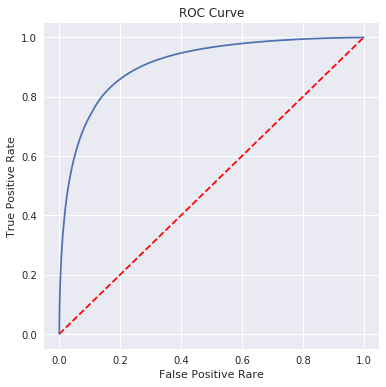

In [144]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(summary.roc.select('FPR').collect(),
         summary.roc.select('TPR').collect())
plt.xlabel('False Positive Rare')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve")
plt.show()

## Conclusions <a class="anchor" id="bullet7"></a>
----------------------

In this two part blog post we went over how to perform Extract-Transform-Load (ETL) for NLP using Spark and MongoDB and then how to build a machine learning model for sentiment analysis using SparkML on the Google Cloud Platform (GCP).  In this post we focused on creating a machine learning model using <a href="https://spark.apache.org/docs/latest/ml-pipeline.html">ML Pipelines</a> starting out with a basic model using TF-IDF and logistic regression. We added different stages to our ML Pipeline such as removing stop words, stemming and using bigrams to see which procedure would improve the predictive performance of our model. In the process we also went over how to write our own custom transformer in PySpark.  Once we settled on using stemming and bigrams in our model we performed a grid search using cross validation to obtain a model that has a AUC of 0.891 in the ROC curve and 81.5% accuracy which is not too shabby! One thing I didn't go over that is valuable is how to persist the ML Pipeline model to use again later without having to retrain, for that see <a href="https://spark.apache.org/docs/latest/ml-pipeline.html#ml-persistence-saving-and-loading-pipelines">here</a>.